# Librerias

In [49]:
import numpy as np # Para hacer calculos cientificos
import pandas as pd # Para manipulación de datos
import matplotlib.pyplot as plt # Para la creación de gráficos
import seaborn as sns # Para la visualización de datos
from yellowbrick.cluster import KElbowVisualizer # Para visualizar un método que eligue la cantidad de clusters
from sklearn.cluster import KMeans # Utilizar el algoritmo Kmeans para crear el Cluster
from sklearn.decomposition import PCA # Utilizar el algoritmo PCA para disminuir el numero de variables

import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias

# Importar, Analizar y transformar los datos

In [50]:
datos = pd.read_csv('datos\QVI_data.csv') # Importar datos

In [51]:
datos.head() # Primeras filas del archivo

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [52]:
datos.info() # Información de los datos del archivo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [53]:
len(datos['LIFESTAGE'].unique()) # cuantas etapas de la vida hay

7

In [54]:
len(datos['PREMIUM_CUSTOMER'].unique()) # cuantos tipos de clientes hay

3

In [55]:
len(datos['LYLTY_CARD_NBR'].unique()) # cuantos clientes hay

72636

In [56]:
# Transformar y añadir algunos datos
datos['LIFESTAGE'].replace(to_replace=['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'NEW FAMILIES', 'MIDAGE SINGLES/COUPLES', 
    'OLDER SINGLES/COUPLES', 'OLDER FAMILIES', 'RETIREES'], value=[1, 2, 3, 4, 5, 6, 7], inplace=True)
datos['PREMIUM_CUSTOMER'].replace(to_replace=['Premium', 'Budget', 'Mainstream'], value=[1, 2, 3], inplace=True)
datos['DATE'] = pd.to_datetime(datos['DATE'])
datos['days_diference'] = (max(datos['DATE'])-datos['DATE']) / pd.offsets.Day(1)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  int64         
 11  PREMIUM_CUSTOMER  264834 non-null  int64         
 12  days_diference    264834 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(8), object(2)
memor

#### Crear los datos de clientes

In [57]:
clientes = datos.groupby('LYLTY_CARD_NBR')
distinct_count = lambda x: len(x.unique())

clientes = clientes.agg({'STORE_NBR' : distinct_count, 'TXN_ID': distinct_count, 'PROD_NBR': distinct_count, 'PROD_QTY': 'mean', 
    'TOT_SALES': 'mean', 'PACK_SIZE': ['min', 'max'], 'BRAND': distinct_count, 'LIFESTAGE': 'max', 
    'days_diference': ['min', 'max'],'PREMIUM_CUSTOMER': 'mean'
})

clientes.columns = ['stores', 'purchases', 'products', 'mean_of_products', 'mean_of_sales', 'min_of_size', 'max_of_size', 
    'brands', 'lifestage', 'min_of_days_difference', 'max_of_days_difference', 'type_of_customer']

clientes.describe()

,stores,purchases,products,mean_of_products,mean_of_sales,min_of_size,max_of_size,brands,lifestage,min_of_days_difference,max_of_days_difference,type_of_customer
count,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000
mean,1.000014,3.622543,3.557107,1.821351,7.098907,146.719203,234.275029,3.026805,4.197616,104.645520,258.950520,2.142133
std,0.003710,2.599395,2.531471,0.368178,2.139034,47.019982,80.239831,1.945703,2.205656,93.306151,93.764655,0.801824
min,1.000000,1.000000,1.000000,1.000000,1.500000,70.000000,70.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,1.800000,5.891958,110.000000,175.000000,1.000000,2.000000,29.000000,205.000000,1.000000
50%,1.000000,3.000000,3.000000,2.000000,7.400000,135.000000,200.000000,3.000000,5.000000,75.000000,289.000000,2.000000
75%,1.000000,5.000000,5.000000,2.000000,8.571429,165.000000,300.000000,4.000000,6.000000,158.000000,335.000000,3.000000
max,2.000000,18.000000,18.000000,5.000000,29.500000,380.000000,380.000000,13.000000,7.000000,364.000000,364.000000,3.000000


<AxesSubplot:xlabel='stores', ylabel='Count'>

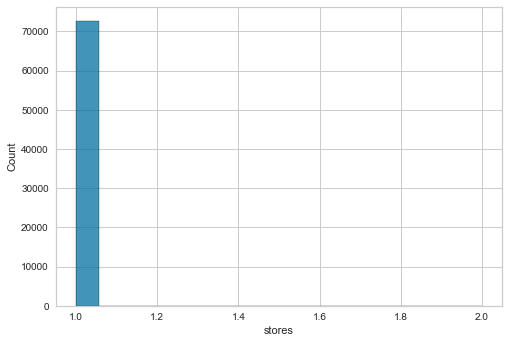

In [58]:
sns.histplot(data=clientes, x="stores") # A cuantas tiendas distintas van los usuarios

In [59]:
clientes_transform = clientes.drop("stores", axis=1) # Borrar esta variable, pues no aporta información

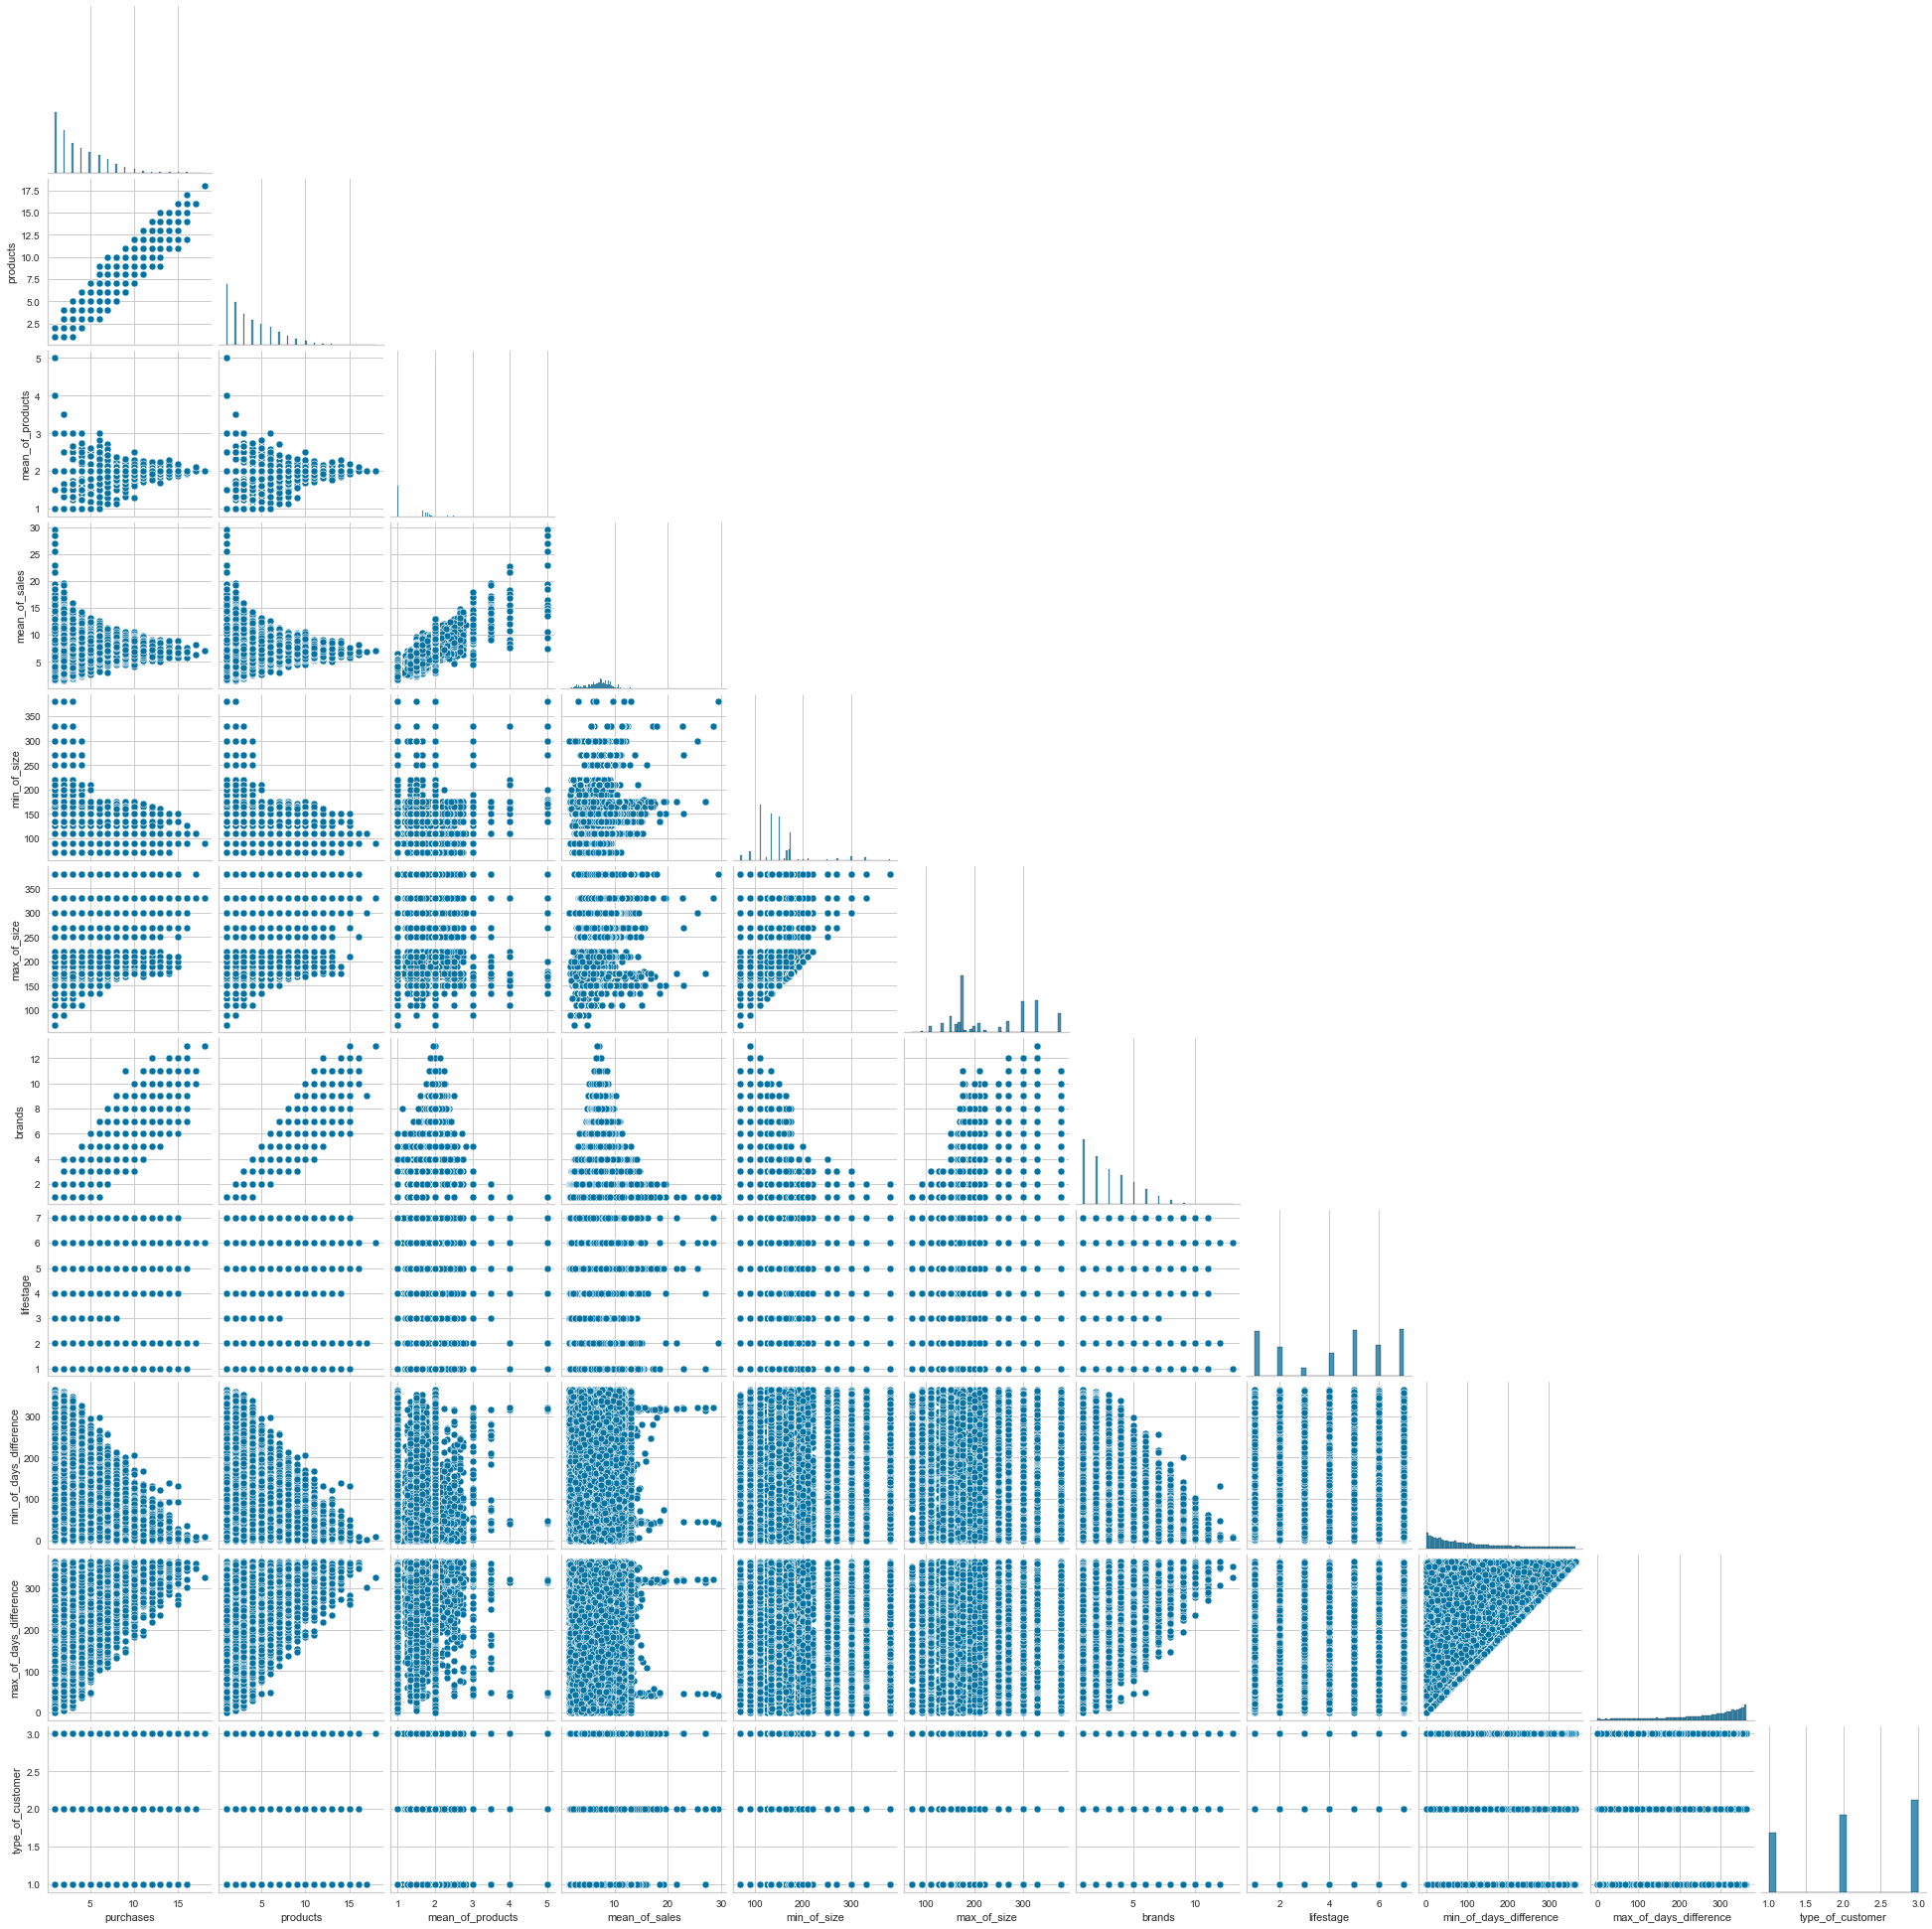

In [60]:
sns.pairplot(clientes_transform, corner=True) # Para ver las relaciones entre los datos

<AxesSubplot:>

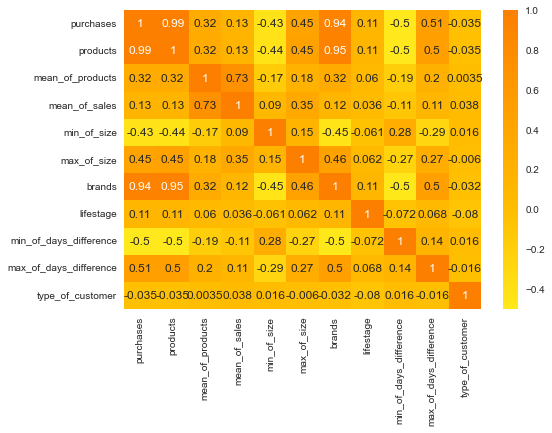

In [61]:
# Matriz de correlación
mat_corr= clientes_transform.corr()
sns.heatmap(mat_corr, cmap = 'Wistia', annot=True, center=0)

In [62]:
clientes_transform.drop(["products", "brands"], axis=1, inplace=True) # Borrar las variables que están correlacionadas con otras

In [63]:
# Normalizar los valores de las columnas. Ya que cada uno está en una escala diferente. Con esta normalización todas las columnas tendrán un minimo igual a 0 y un máximo igual a 1
clientes_norm = ( clientes_transform-clientes_transform.min() ) / (clientes_transform.max()-clientes_transform.min())
clientes_norm.describe()

,purchases,mean_of_products,mean_of_sales,min_of_size,max_of_size,lifestage,min_of_days_difference,max_of_days_difference,type_of_customer
count,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000
mean,0.154267,0.205338,0.199961,0.247481,0.529919,0.532936,0.287488,0.711403,0.571067
std,0.152906,0.092045,0.076394,0.151677,0.258838,0.367609,0.256336,0.257595,0.400912
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.200000,0.156856,0.129032,0.338710,0.166667,0.079670,0.563187,0.000000
50%,0.117647,0.250000,0.210714,0.209677,0.419355,0.666667,0.206044,0.793956,0.500000
75%,0.235294,0.250000,0.252551,0.306452,0.741935,0.833333,0.434066,0.920330,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Aplicar Método K-Means

Text(0, 0.5, 'WCSS')

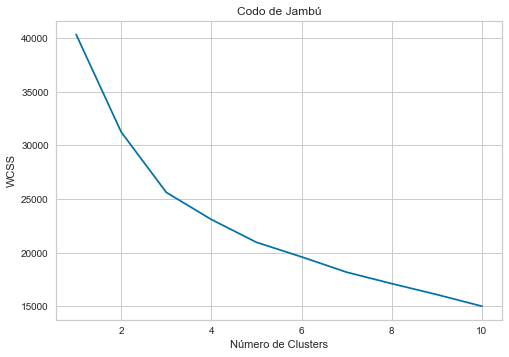

In [64]:
# Elegir la cantidad de Clusters a formar. Para ello utilizaremos un método que se llama codo de jambu 
wcss = [] # within-cluster sums of squares es la medida que se utiliza para medir la distancia de los dato a los clusters

for eleccion_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=eleccion_clusters, max_iter=300) # Definimos el algoritmo KMeans
    kmeans.fit(clientes_norm) # Entrenar el algoritmo con los datos normalizados
    wcss.append(kmeans.inertia_) # Agregar las distancias de cada elección del numero de clusters

# Graficar los resultados anteriores
plt.plot(range(1, 11), wcss) # Especificar los datos
plt.title("Codo de Jambú")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS")

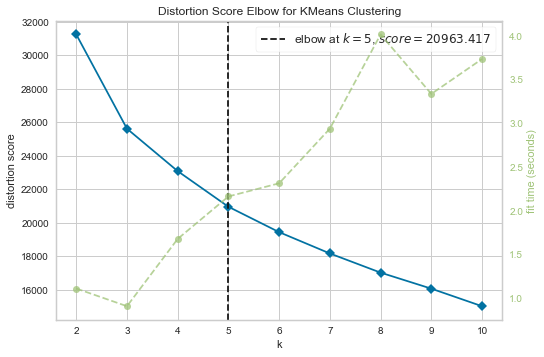

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:
# Se puede realizar el mismo proceso que el anterior con una función llamada KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(max_iter=300), k=10)
Elbow_M.fit(clientes_norm)
Elbow_M.show()

#### Aplicar el método KMeans a la elección de clusters definitiva

In [66]:
eleccion_clusters_definitivo = 5 # Elegimos este valor porque es donde parece que el valor de WCSS deja de disminuir de forma drastica
clustering = KMeans(n_clusters=eleccion_clusters_definitivo, max_iter=300, algorithm="elkan")
clustering.fit(clientes_norm)

# Agregar la clasifición del cluster a clientes
clientes["Cluster_KMeans"] = clustering.labels_
clientes.head()

,stores,purchases,products,mean_of_products,mean_of_sales,min_of_size,max_of_size,brands,lifestage,min_of_days_difference,max_of_days_difference,type_of_customer,Cluster_KMeans
LYLTY_CARD_NBR,,,,,,,,,,,,,
1000,1,1,1,2.0,6.0,175,175,1,1,256.0,256.0,1.0,4
1002,1,1,1,1.0,2.7,150,150,1,1,287.0,287.0,3.0,1
1003,1,2,2,1.0,3.3,175,210,2,2,114.0,115.0,2.0,4
1004,1,1,1,1.0,1.9,160,160,1,5,240.0,240.0,3.0,2
1005,1,1,1,1.0,2.8,165,165,1,4,184.0,184.0,3.0,2


# Visualizar los clusters

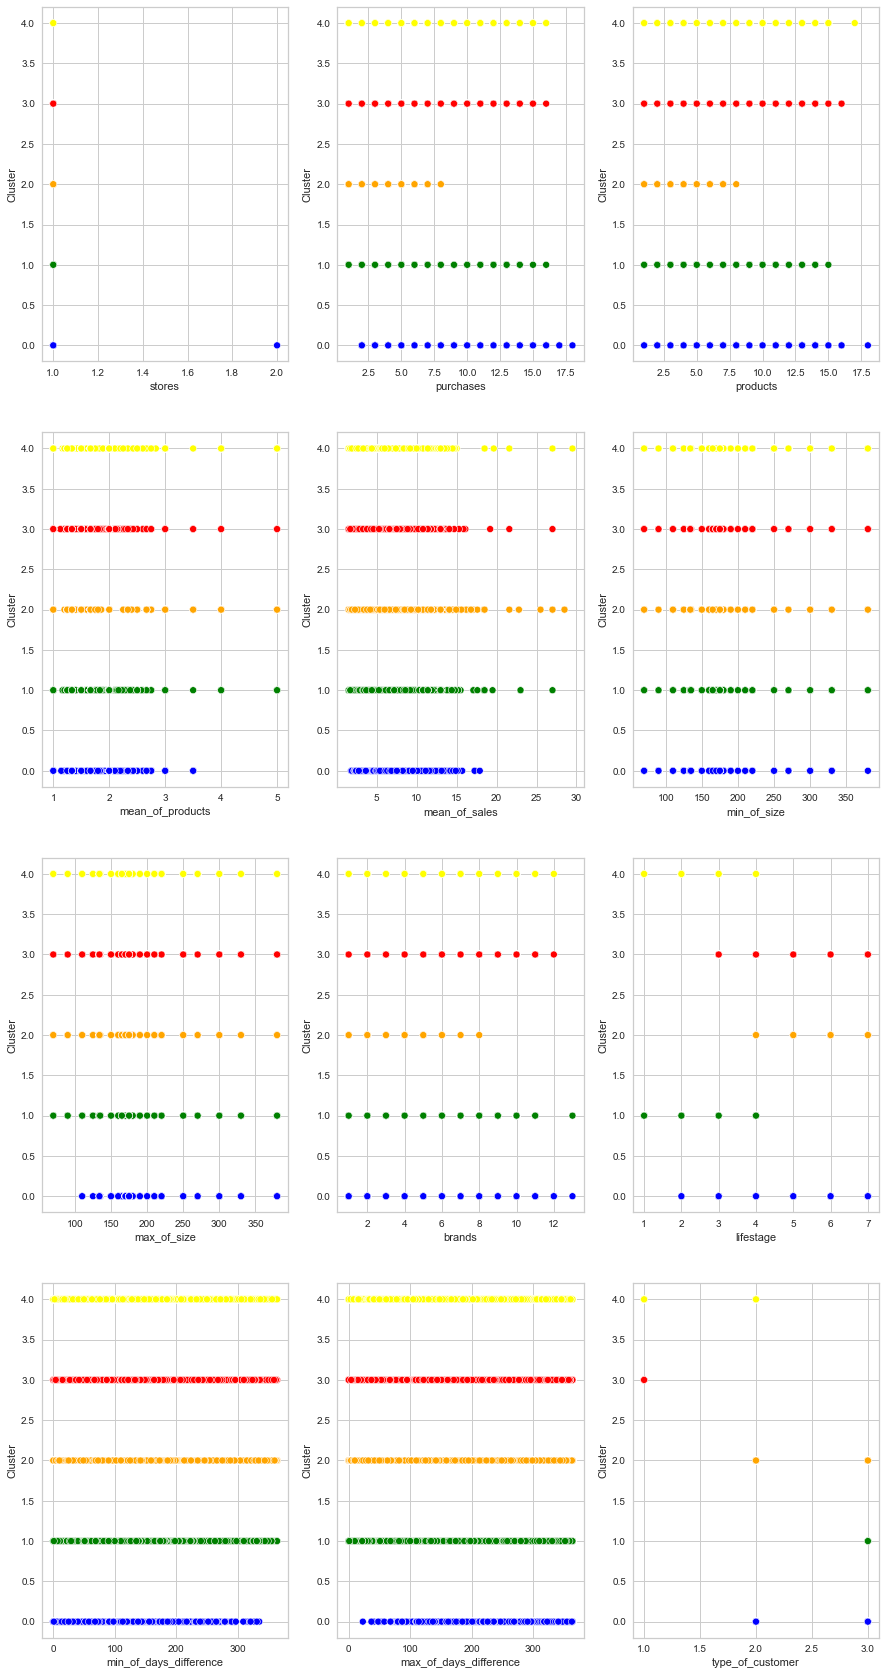

In [67]:
# Visualizar de cada Variable la clasificación del Cluster
position = 1
columnas = clientes.columns.drop("Cluster_KMeans") # Eliminar el elemento Cluster_KMeans de la lista
num_of_plots = len(columnas)
num_of_lines = int(num_of_plots/3)

if(num_of_plots%3>0): res=1 
else: res=0
num_of_lines += res

color_theme = np.array(["blue", "green", "orange", "red", "yellow"])

fig = plt.figure(figsize=(15,30))

for variable in columnas:
    ax = plt.subplot(num_of_lines, 3, position)
    ax = sns.scatterplot(data=clientes, x=variable, y="Cluster_KMeans", 
        c=color_theme[clientes.Cluster_KMeans], legend=False)
    ax = plt.xlabel(variable)
    ax = plt.ylabel('Cluster')
    position += 1

###  Visualizar en 3D la clasificación del Cluster

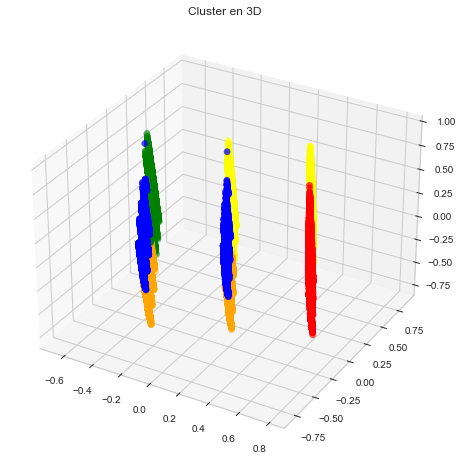

In [68]:
# Para ello se va a aplicar el análisis de componentes principales (PCA)
pca = PCA(n_components=3) # Definimos el algoritmo PCA. En este caso queremos 3 componentes para poder graficar los resultados en 3D
pca_clientes = pca.fit_transform(clientes_norm) # Entrenar el algoritmo con los datos normalizados
pca_clientes_df = pd.DataFrame(data=pca_clientes) # Crear un DataFrame con los resultados del algoritmo PCA
cluster = pd.DataFrame(data=clientes["Cluster_KMeans"].values)
pca_clientes_y_cluster = pd.concat([pca_clientes_df, cluster], axis=1, ignore_index=True) # Añadir la información del Cluster al que pertenecen
pca_clientes_y_cluster.columns = ['Componente_1', 'Componente_2', 'Componente_3', 'Cluster_KMeans']

# Graficar los resultados
x=pca_clientes_y_cluster["Componente_1"]
y=pca_clientes_y_cluster["Componente_2"]
z=pca_clientes_y_cluster["Componente_3"]

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1, 1, 1, projection='3d', label="bla")
ax.scatter(x, y, z, 
        s=40, marker='o', 
        c=color_theme[pca_clientes_y_cluster.Cluster_KMeans]
        )
ax.set_title("Cluster en 3D")
plt.show()

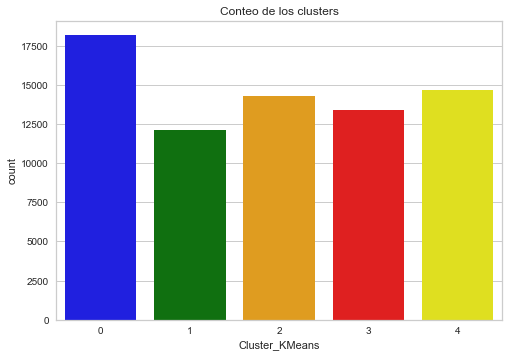

In [69]:
distrib_cluster = sns.countplot(x=clientes["Cluster_KMeans"], palette= color_theme)
distrib_cluster.set_title("Conteo de los clusters")
plt.show()

# Guardar los resultados

In [70]:
# Guardar los datos junto con el cluster asignado
clientes.to_csv('datos\clientes_con_cluster.csv')